# Imports, FSL initialization and data preparation

In [1]:
# Various imports

%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

os.environ["DIPY_HOME"] = "/home/jovyan/Data"

#############################
# Loading fsl and freesurfer within Neurodesk
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths, epi_reg

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

!pip install antspyx
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet, flirt, mcflirt
from fsl.wrappers.misc import fslroi

# Nilearn functions for GLM
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_contrast_matrix
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.image import mean_img, concat_imgs

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
from mne.datasets import sample
import matplotlib.pyplot as plt

# Scattered import found throughout the labs
from nipype.interfaces.fsl import FAST
import subprocess

In [3]:
# Open FSL eyes

fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

12:27:01: Debug: Adding duplicate image handler for 'Windows bitmap file'
12:27:01: Debug: Adding duplicate animation handler for '1' type
12:27:01: Debug: Adding duplicate animation handler for '2' type
12:27:01: Debug: Adding duplicate image handler for 'Windows bitmap file'
12:27:01: Debug: Adding duplicate animation handler for '1' type
12:27:01: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:12460): Gtk-CRITICAL **: 12:27:02.766: gtk_window_resize: assertion 'height > 0' failed


In [4]:
# Functions to download dataset

def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')

In [5]:
# Download dataset

dataset_fmap = 'ds000171'
subject_fmap = '001'

# Main directory
bids_root = op.join(op.dirname(sample.data_path()), dataset_fmap)

# Paths for functional and anatomical data
func_path = op.join(bids_root, 'sub-control01', 'func')
anat_path = op.join(bids_root, 'sub-control01', 'anat')
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

# Create directories for func and anat
mkdir_no_exist(bids_root)
mkdir_no_exist(op.join(bids_root, 'sub-control01'))
mkdir_no_exist(func_path)
mkdir_no_exist(anat_path)
mkdir_no_exist(deriv_root)
mkdir_no_exist(preproc_root)

# List of functional files to download
file_list = [
    'sub-control01_task-music_run-1_bold.nii.gz',
    'sub-control01_task-music_run-1_events.tsv',
    'sub-control01_task-music_run-2_bold.nii.gz',
    'sub-control01_task-music_run-2_events.tsv',
    'sub-control01_task-music_run-3_bold.nii.gz',
    'sub-control01_task-music_run-3_events.tsv',
]

file_types = ['func'] * len(file_list)
save_dirs = [func_path] * len(file_list)


direct_file_download_open_neuro(file_list=file_list, 
                                 file_types=file_types, 
                                 dataset_id=dataset_fmap, 
                                 dataset_version='00001', 
                                 save_dirs=save_dirs)

# List of anatomical files to download
anat_file_list = ['sub-control01_T1w.nii.gz']

# For the anac files, define their types and save directories
anat_file_types = ['anat'] * len(anat_file_list)
anat_save_dirs = [anat_path] * len(anat_file_list)

# Download anatomical files
direct_file_download_open_neuro(file_list=anat_file_list, 
                                 file_types=anat_file_types, 
                                 dataset_id=dataset_fmap, 
                                 dataset_version='00001', 
                                 save_dirs=anat_save_dirs)

otherfiles_list = [
    'CHANGES',
    'README',
    'dataset_description.json',
    'T1w.json',
    'participants.tsv',
    'task-music_bold.json',
    'task-nonmusic_bold.json'
]

for filename in otherfiles_list:
    # Construct the download link for these files
    download_link = f'https://openneuro.org/crn/datasets/{dataset_fmap}/snapshots/00001/files/{filename}'
    print(f'Attempting download from: {download_link}')
    # Download the file without specifying file_type
    download_url(download_link, op.join(bids_root, filename))
    print('Downloaded:', filename)

Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-1_bold.nii.gz


sub-control01:func:sub-control01_task-music_run-1_bold.nii.gz: 35.5MB [00:15, 2.31MB/s]                


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-1_events.tsv


sub-control01:func:sub-control01_task-music_run-1_events.tsv: 8.19kB [00:00, 23.1kB/s]


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-2_bold.nii.gz


sub-control01:func:sub-control01_task-music_run-2_bold.nii.gz: 35.5MB [00:02, 13.0MB/s]                


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-2_events.tsv


sub-control01:func:sub-control01_task-music_run-2_events.tsv: 8.19kB [00:00, 12.6kB/s]


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-3_bold.nii.gz


sub-control01:func:sub-control01_task-music_run-3_bold.nii.gz: 35.5MB [00:14, 2.42MB/s]                


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-3_events.tsv


sub-control01:func:sub-control01_task-music_run-3_events.tsv: 8.19kB [00:00, 12.7kB/s]


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:anat:sub-control01_T1w.nii.gz


sub-control01:anat:sub-control01_T1w.nii.gz: 9.21MB [00:01, 6.38MB/s]                


Ok
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/CHANGES


CHANGES: 8.19kB [00:00, 15.9kB/s]


Downloaded: CHANGES
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/README


README: 8.19kB [00:00, 15.5kB/s]


Downloaded: README
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/dataset_description.json


dataset_description.json: 8.19kB [00:00, 15.5kB/s]


Downloaded: dataset_description.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/T1w.json


T1w.json: 8.19kB [00:00, 12.9kB/s]


Downloaded: T1w.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/participants.tsv


participants.tsv: 8.19kB [00:00, 14.5kB/s]


Downloaded: participants.tsv
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/task-music_bold.json


task-music_bold.json: 8.19kB [00:00, 15.4kB/s]


Downloaded: task-music_bold.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/task-nonmusic_bold.json


task-nonmusic_bold.json: 8.19kB [00:00, 14.9kB/s]

Downloaded: task-nonmusic_bold.json


In [6]:
# Data standardization

# Load the individual fMRI runs
run1 = nib.load(op.join(func_path, 'sub-control01_task-music_run-1_bold.nii.gz'))
run2 = nib.load(op.join(func_path, 'sub-control01_task-music_run-2_bold.nii.gz'))
run3 = nib.load(op.join(func_path, 'sub-control01_task-music_run-3_bold.nii.gz'))

concatenated_file_path = '/home/jovyan/mne_data/ds000171/sub-control01/func/sub-control01_task-music_concatenated_bold.nii.gz'

def standardize_img(img):
    data = img.get_fdata()
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / std
    return nib.Nifti1Image(standardized_data, img.affine)

run1_standardized = standardize_img(run1)
run2_standardized = standardize_img(run2)
run3_standardized = standardize_img(run3)

concatenated_img = concat_imgs([run1_standardized, run2_standardized, run3_standardized])

nib.save(concatenated_img, concatenated_file_path)

print("Concatenation complete and saved as 'sub-control01_task-music_concatenated_bold.nii.gz'.")

Concatenation complete and saved as 'sub-control01_task-music_concatenated_bold.nii.gz'.


In [6]:
# Display standardized data

fsleyesDisplay.resetOverlays()

if op.exists(concatenated_file_path):
    fsleyesDisplay.load(concatenated_file_path)
    
    print("Loaded:", concatenated_file_path)
else:
    print("File does not exist at the specified path.")


(ipykernel_launcher.py:1480): Gdk-WARNING **: 09:59:47.635: gdkdrawable-x11.c:952 drawable is not a pixmap or window


Loaded: /home/jovyan/mne_data/ds000171/sub-control01/func/sub-control01_task-music_concatenated_bold.nii.gz


# Preprocessing

## Path defining

In [7]:
subject_id = "control01"
subject = "sub-{}".format(subject_id)

preproc_anat_path = op.join(preproc_root, subject, 'anat')
preproc_func_path = op.join(preproc_root, subject, 'func')
mkdir_no_exist(preproc_anat_path)
mkdir_no_exist(preproc_func_path)

# Bids
anatomical_path = op.join(anat_path, '{}_T1w.nii.gz'.format(subject))  
original_epi = op.join(func_path, '{}_task-music_concatenated_bold.nii.gz'.format(subject))

# Preprocessing
## Anatomical
betted_brain_path = op.join(preproc_anat_path, '{}_T1w.nii.gz'.format(subject))  # Skull-stripping
resulting_mask_path = op.join(preproc_anat_path, '{}_T1w_mask.nii.gz'.format(subject))  # Mask
segmentation_path = op.join(preproc_anat_path, '{}_T1w_fast'.format(subject)) # Segmentation
anat_result = op.join(preproc_anat_path, '{}_T1w_mni'.format(subject)) # Coregistration
anat_2_mni_trans = op.join(preproc_anat_path, '{}_T1w_2_mni_lin.mat'.format(subject))

## Functional
reference_epi = op.join(preproc_func_path, '{}_task-music_concatenated_bold_first_volume.nii.gz'.format(subject))
path_moco_data = op.join(preproc_func_path, '{}_task-music_concatenated_bold_moco.nii.gz'.format(subject)) # Motion correction
output_path = op.join(preproc_func_path, '{}_task-sitrep_run-01_bold_anat-space'.format(subject))

smoothing_param = 10
smoothing_path = op.join(preproc_func_path, '{}_task-music_concatenated_bold_moco_smoothed-{}mm.nii.gz'.format(subject, smoothing_param)) # Smoothing
func_result = smoothing_path

# Other
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain')) # MNI template

## Voxel intensity

Text(0, 0.5, 'Mean voxel intensity')

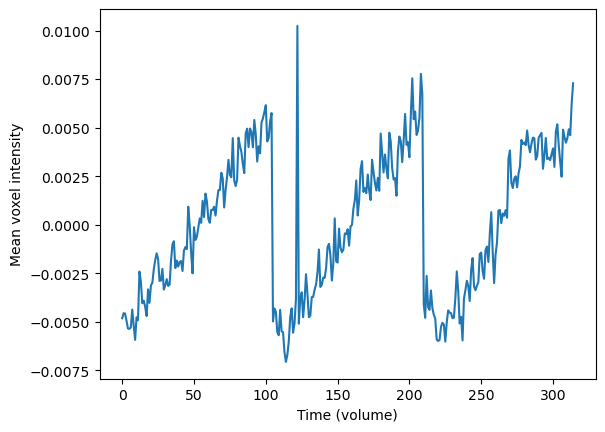

In [8]:
# Check the contrast
# looking at the y-axis I guess we are fine (?)
# I checked there are 315 volumes

plt.plot(nib.load(original_epi).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [9]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- task-nonmusic_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_concatenated_bold.nii.gz
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv


In [26]:
data = json.load(open(op.join(bids_root,'task-music_bold.json')))

slice_timing = data['SliceTiming']
tr = data ['RepetitionTime']

slice_order = np.argsort(slice_timing)+1

timing_path = op.join(preproc_root, 'sub-control01','func','sub-control01_task-sitrep_run-01_slice-timings.txt')
file = open(timing_path, mode='w')
for t in slice_order : 
    file.write(str(t) + '\n')
file.close()

file_to_realign = op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold.nii.gz')
output_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_slice-corr.nii.gz')

subprocess.run(['slicetimer','-i',file_to_realign,'-o',output_target,'-r',str(tr),'--ocustom='+timing_path])

CompletedProcess(args=['slicetimer', '-i', '/home/jovyan/mne_data/ds000171/sub-control01/func/sub-control01_task-music_concatenated_bold.nii.gz', '-o', '/home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_slice-corr.nii.gz', '-r', '3.0', '--ocustom=/home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_slice-timings.txt'], returncode=0)

## MCFLIRT

In [27]:
fslroi(original_epi, reference_epi, str(0), str(1)) 
mcflirt(infile=output_target,o=path_moco_data, plots=True, report=True, dof=6, mats=True, reffile=reference_epi)

Processed data will be saved as /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_moco.nii.gz

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [-1] to 8 mm pixels
Registering volumes ... [0][1][2][3][4][5][6][7][8][9][10][11][12][13][14][15][16][17][18][19][20][21][22][23][24][25][26][27][28][29][30][31][32][33][34][35][36][37][38][39][40][41][42][43][44][45][46][47][48][49][50][51][52][53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][146][147][148][149][150][151][1

{}

In [28]:
# Relevant variables for epi_reg
dwell_time = 0.025 #0.000620007
unwarpdir='y-'

# Skull stripping (BET)
subprocess.run(['bet', anatomical_path, betted_brain_path, '-m', '-R'])

# Segmentation (FAST)
fast(imgs=[betted_brain_path], out=segmentation_path, n_classes=3)

# Coregistration (FLIRT)
flirt(betted_brain_path, mni_template, out=anat_result, omat = anat_2_mni_trans)

# Unwarping
subprocess.run(['epi_reg','--epi={}'.format(reference_epi), 
                '--t1={}'.format(anatomical_path), 
                '--t1brain={}'.format(betted_brain_path), 
                '--out={}'.format(output_path),
                '--fmap={}'.format(op.join(preproc_root, subject, 'fmap', 'fieldmap_ex_rads')),
                '--fmapmagbrain={}'.format(op.join(preproc_root, subject, 'fmap', 'fieldmap_ex_mag_brain')),
                '--fmapmag={}'.format(op.join(preproc_root, subject, 'fmap', 'fieldmap_ex_mag')),
                '--wmseg={}'.format(op.join(preproc_root, subject, 'anat', 'sub-control01_T1w_fast_pve_2')),
                '--echospacing={}'.format(dwell_time),
                '--pedir={}'.format(unwarpdir)])

print("Done with EPI to anatomical registration with fieldmap unwarping")

FLIRT pre-alignment
Registering fieldmap to structural


Image Exception : #63 :: No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/fmap/fieldmap_ex_mag_brain
Image Exception : #22 :: Failed to read volume /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/fmap/fieldmap_ex_mag_brain
Error : No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/fmap/fieldmap_ex_mag_brain
Failed to read volume /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/fmap/fieldmap_ex_mag_brain
Error : No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/fmap/fieldmap_ex_mag_brain
Image Exception : #63 :: No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/fmap/fieldmap_ex_mag
Image Exception : #22 :: Failed to read volume /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/fmap/fieldmap_ex_mag
Error : No image files match

Running BBR with fieldmap


Image Exception : #63 :: No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_fieldmaprads2str
Image Exception : #22 :: Failed to read volume /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_fieldmaprads2str
Error : No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_fieldmaprads2str
Failed to read volume /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_fieldmaprads2str
Error : No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_fieldmaprads2str
Could not open matrix file /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-co

Making warp fields and applying registration to EPI series


/opt/fsl-6.0.7.4/bin/epi_reg: line 390: 15686 Aborted                 (core dumped) $FSLDIR/bin/fslmaths ${vout}_fieldmaprads2epi -abs -bin ${vout}_fieldmaprads2epi_mask
Image Exception : #63 :: No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_fieldmaprads2epi_mask
Image Exception : #22 :: Failed to read volume /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_fieldmaprads2epi_mask
Error : No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_fieldmaprads2epi_mask
terminate called after throwing an instance of 'std::runtime_error'
  what():  Failed to read volume /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_fieldmaprads2epi_mask
E

Done with EPI to anatomical registration with fieldmap unwarping


Image Exception : #63 :: No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_warp
Image Exception : #22 :: Failed to read volume /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_warp
Error : No image files match: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_warp
An error occured while reading file: /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_bold_anat-space_warp


### Motion outliers

In [29]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.nii.gz.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.000000,-0.000000,0.000000,-2.132660e-03,0.000000,0.000000
1,-0.000402,-0.000312,0.000000,-1.219740e-02,0.011809,0.009932
2,-0.000765,-0.000000,0.000000,-2.785330e-10,0.027017,0.023216
3,-0.000275,0.000288,-0.000307,-7.734160e-03,0.030794,0.004766
4,0.000416,0.000064,-0.000194,-1.335210e-02,0.030318,-0.025599
...,...,...,...,...,...,...
310,0.017628,-0.003635,-0.002526,-7.604010e-03,1.069160,0.836696
311,0.017576,-0.004216,-0.002526,-7.204180e-03,1.040640,0.825369
312,0.017791,-0.004372,-0.002526,-7.096720e-03,1.067160,0.829909
313,0.017152,-0.004493,-0.002526,-2.849140e-02,1.043570,0.810238


In [30]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

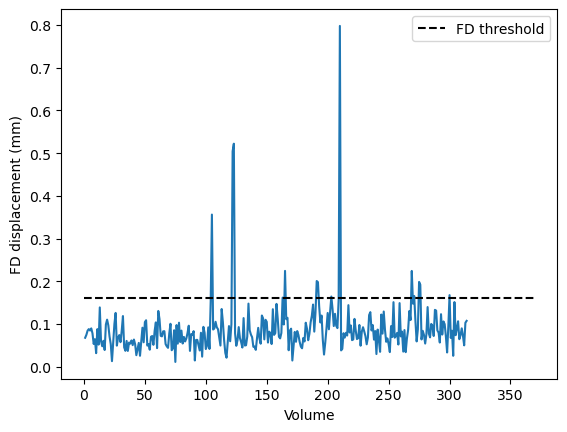

In [31]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

### Smoothing

In [32]:
smoothing_param = 10

In [33]:
# Smoothing

cmd = 'fslmaths {} -s {} {}_smoothed-{}mm'.format(output_path, smoothing_param/2.3548, output_path, smoothing_param)
subprocess.run(['fslmaths',path_moco_data, '-s', str(smoothing_param/2.3548), smoothing_path])



CompletedProcess(args=['fslmaths', '/home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_moco.nii.gz', '-s', '4.246645150331238', '/home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_moco_smoothed-10mm.nii.gz'], returncode=0)

In [29]:
# See smoothing

fsleyesDisplay.load(smoothing_path)

In [34]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- task-nonmusic_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_2_mni_lin.mat
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mni.nii.gz
|------------ func/
|--------------- sub-control01_task-music_concatenated_bold_first_volume.nii.gz
|--------------- sub-control01_task-music_concatenated_bold_moco.nii.gz
|--------------- sub-control01_task-music_concatenated_bold_moco.nii.gz.par

# GLM

In [35]:
evt1=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
evt2=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
evt3=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-3_events.tsv'), sep='\t')

evt_concat=pd.concat([evt1,evt2,evt3], ignore_index=True)
evt_concat['onset']=evt_concat['duration'].shift(1).cumsum().fillna(0)
evt_concat

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [36]:
TR = 3  # Repetition time (in seconds)
total_time = 936  # Total time of the scan in seconds
time_points = np.arange(0, total_time, TR)

In [39]:
fmri_img = smoothing_path
anat_img = betted_brain_path

In [45]:
# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)

fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='polynomial',
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, evt_concat)
design_matrix = fmri_glm.design_matrices_[0]

reg = np.zeros(315)
reg[np.where(fd>threshold)[0]+1]=1
design_mat_regged = design_matrix.copy()
design_mat_regged['motion outlier'] = reg

fmri_glm_reg=fmri_glm.fit(fmri_img, design_matrices=[design_mat_regged])
design_matrix = fmri_glm_reg.design_matrices_[0]

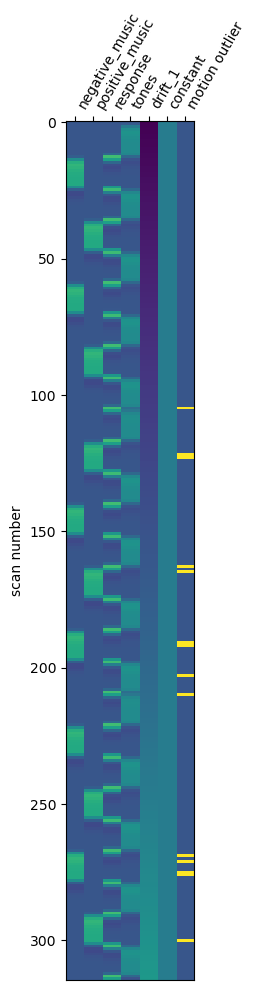

In [46]:
plot_design_matrix(design_matrix)
plt.show()

In [47]:
regressors = {
    'negative_music': np.array([1, 0, 0,0,0,0,0]), 
    'positive_music':np.array([0, 1,0, 0,0,0,0]), 
    'response':np.array([0, 0,1, 0,0,0,0]), 
    'tones':np.array([0, 0, 0,1,0,0,0]) 
}

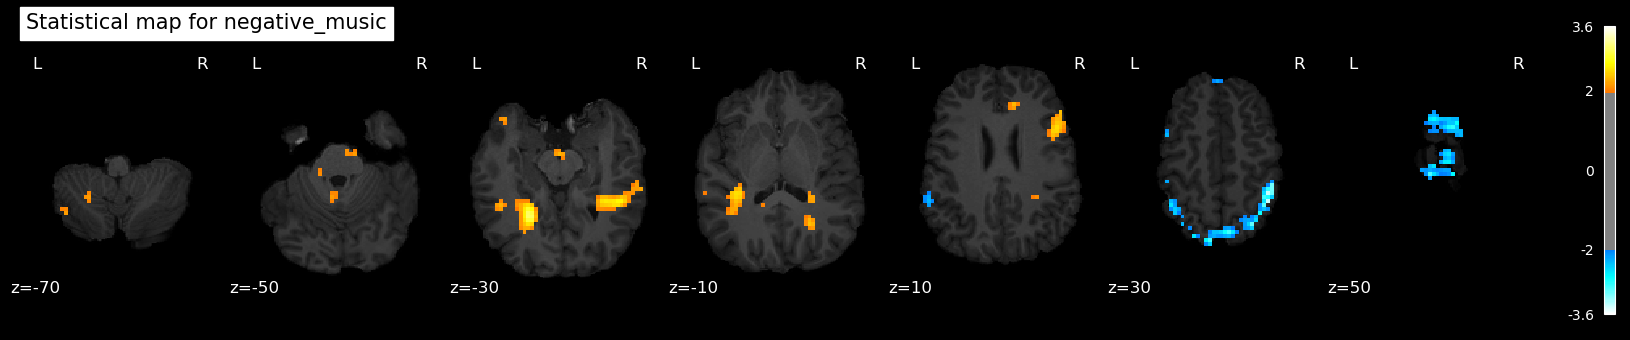

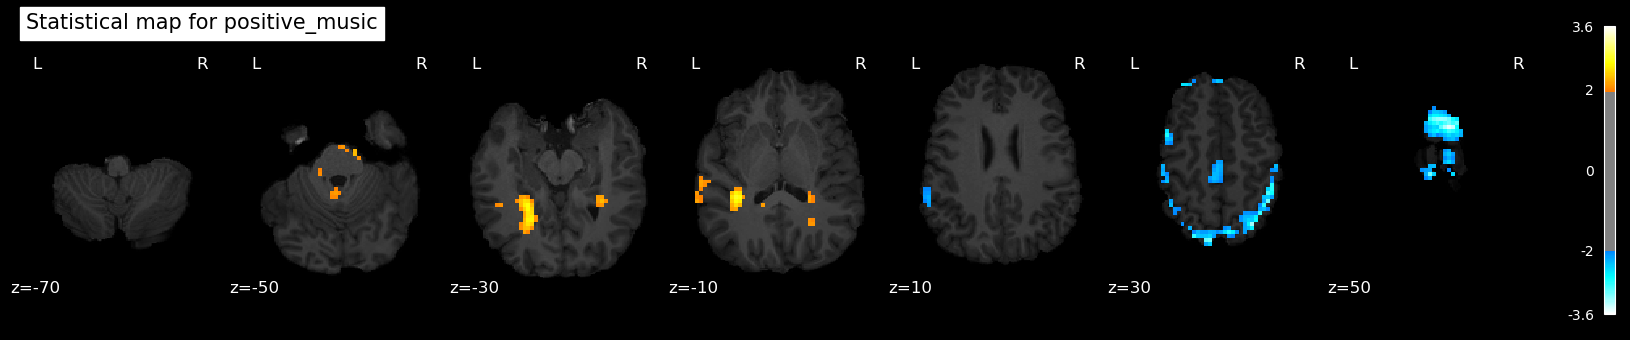

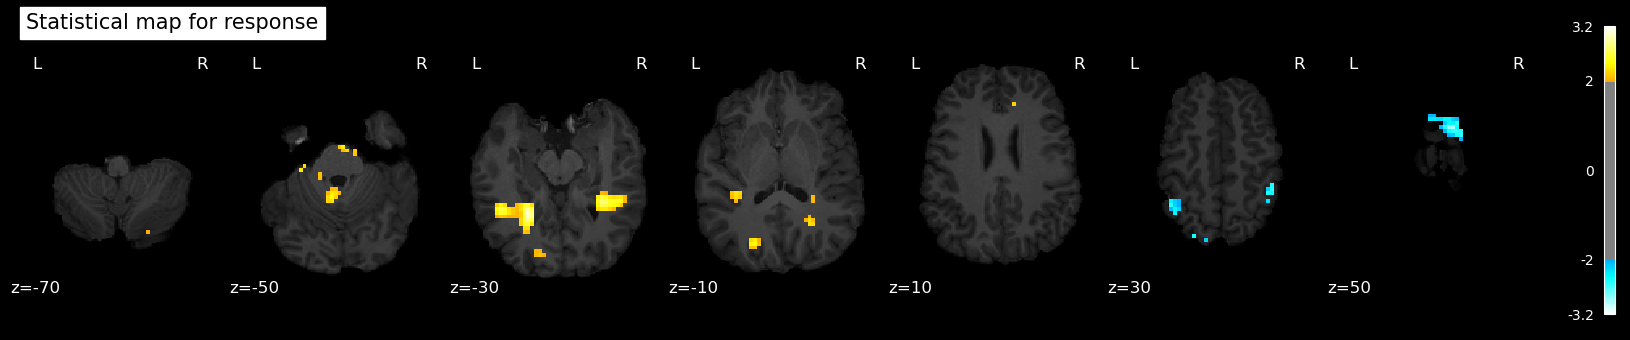

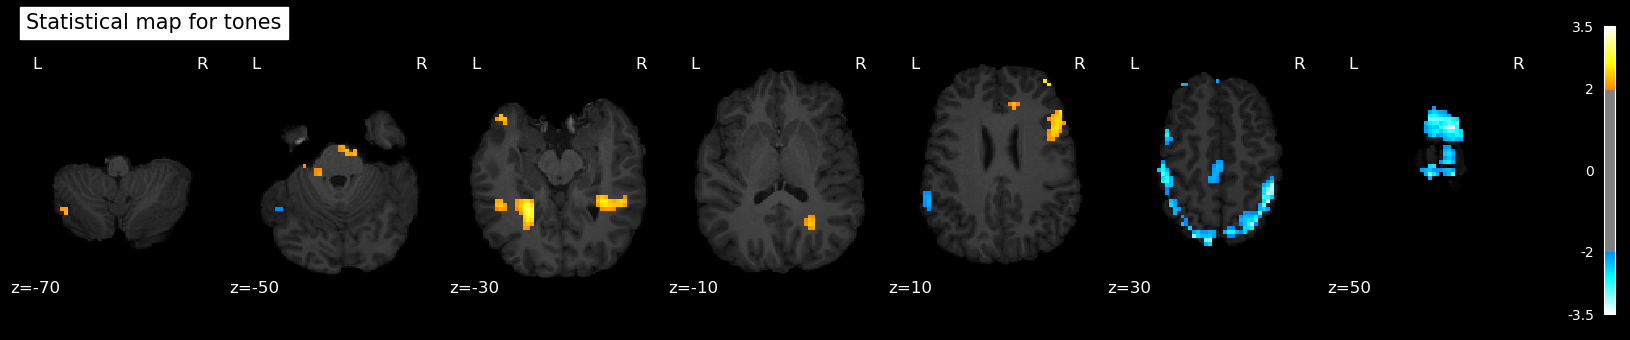

In [48]:
for regressor in regressors:
    z_map = fmri_glm.compute_contrast(regressors[regressor], output_type='z_score')
    plot_stat_map(z_map, bg_img=anat_img, title='Statistical map for {}'.format(regressor), display_mode='z', threshold=2, black_bg=True, cut_coords=[-70, -50, -30, -10, 10, 30, 50])

In [49]:
contrasts = {
    'pos_vs_neg' : regressors['positive_music'] - regressors['negative_music'],
    'pos_vs_neu' : regressors['positive_music'] - regressors['tones'],
    'neg_vs_neu' : regressors['negative_music'] - regressors['tones']
}


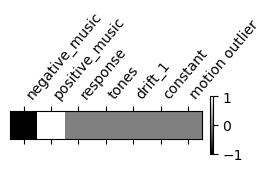

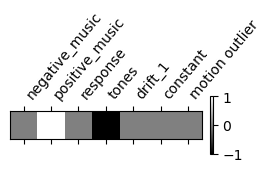

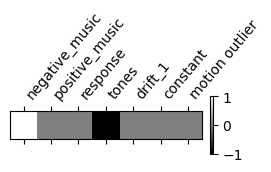

In [50]:
for contrast, weights in contrasts.items():
    plot_contrast_matrix(weights, design_matrix=fmri_glm.design_matrices_[0],colorbar=True)  

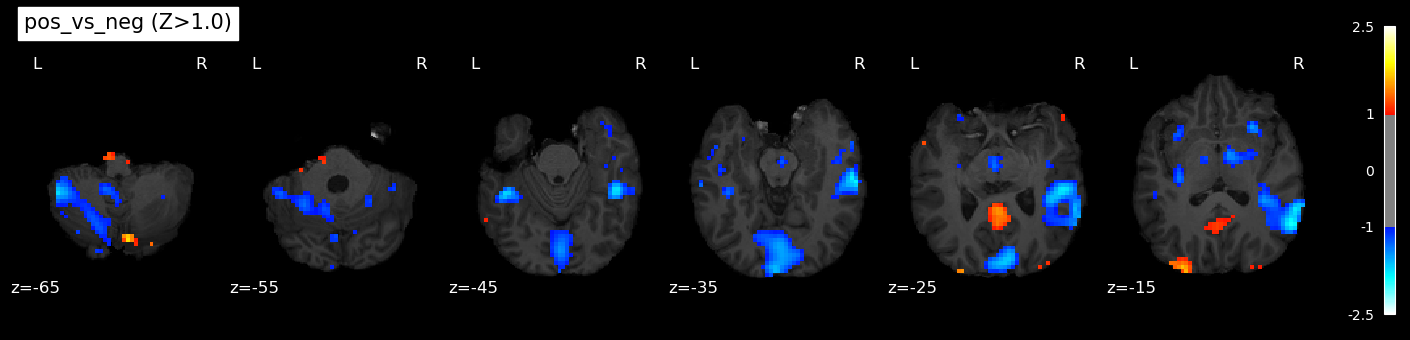

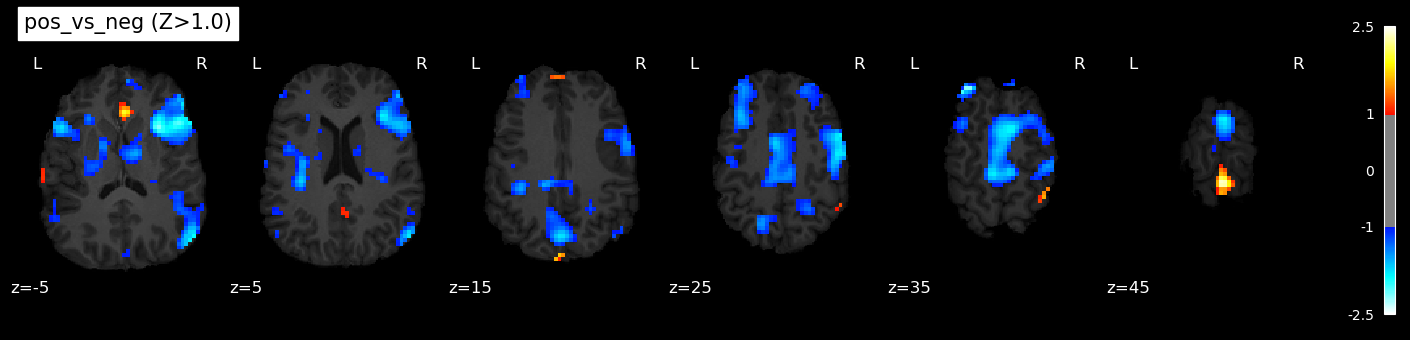

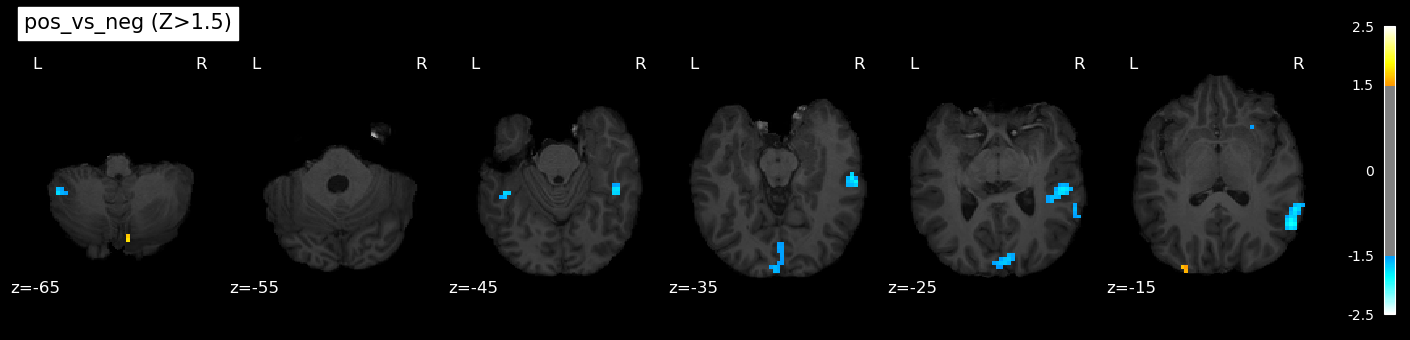

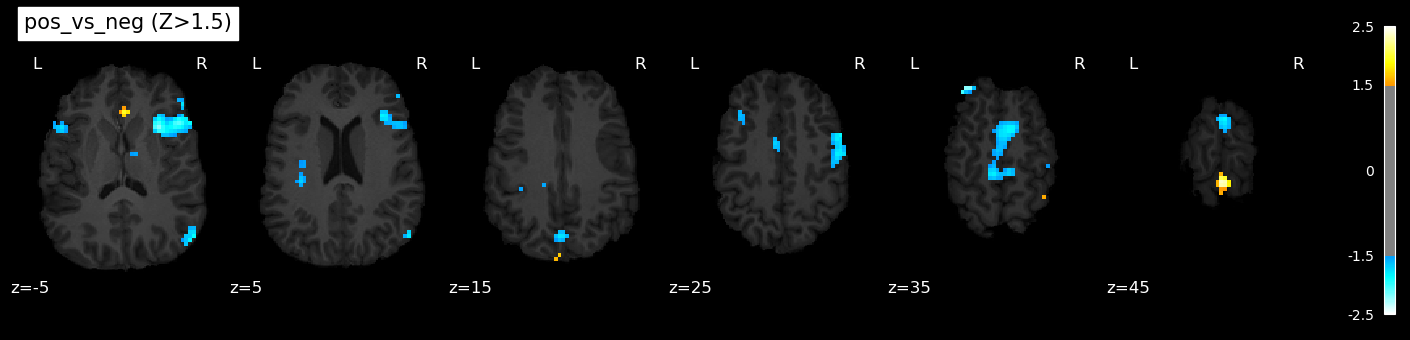

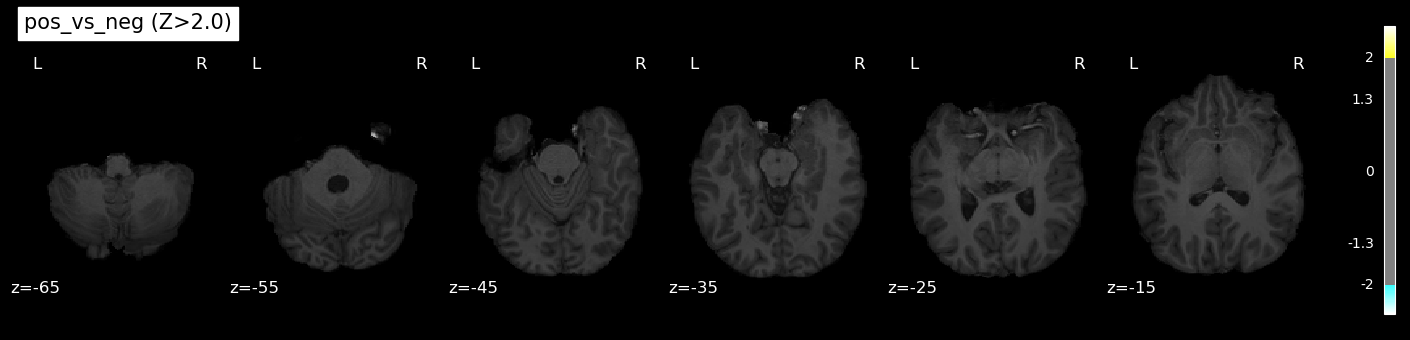

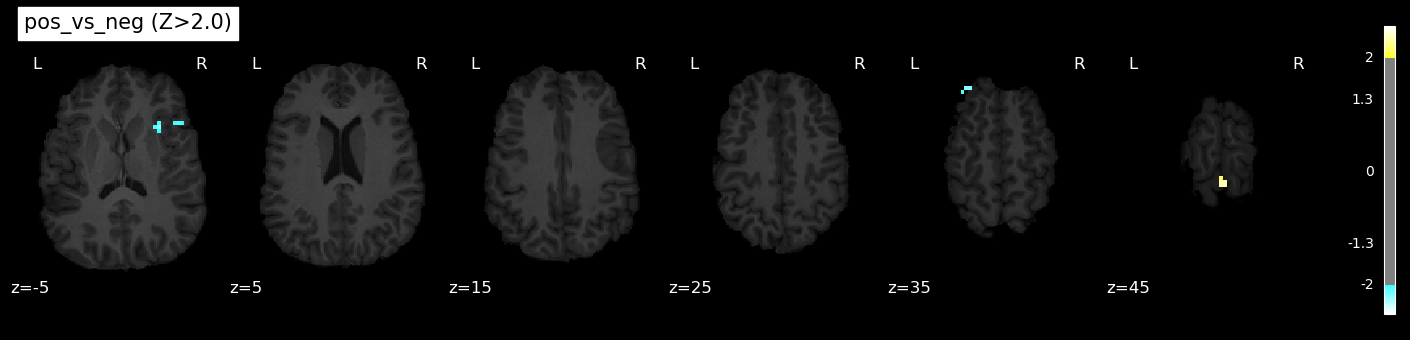

In [53]:
thresholds = [1.0,1.5,2.0]
contrast = 'pos_vs_neg'
weights = contrasts[contrast]

for threshold in thresholds:
    z_map = fmri_glm.compute_contrast(weights,
                                      output_type='z_score')
    
    nib.save(z_map, 'z_map_uncorrected_' + str(contrast) + '.nii.gz')
    plot_stat_map(z_map, bg_img=anat_img, threshold=threshold,
                  display_mode='z', cut_coords=[-65,-55,-45,-35,-25,-15], black_bg=True,
                  title=str(contrast)+' (Z>{})'.format(str(threshold)))
    plt.show()
    plot_stat_map(z_map, bg_img=anat_img, threshold=threshold,
                  display_mode='z', cut_coords=[-5,5,15,25,35,45], black_bg=True,
                  title=str(contrast)+' (Z>{})'.format(str(threshold)))
    plt.show()


In [ ]:
thresholds = [1.0,1.5,2.0]
contrast = 'pos_vs_neg'
weights = contrasts[contrast]

for threshold in thresholds:
    z_map = fmri_glm.compute_contrast(weights,
                                      output_type='z_score')
    
    nib.save(z_map, 'z_map_uncorrected_' + str(contrast) + '.nii.gz')
    plot_stat_map(z_map, bg_img=anat_img, threshold=threshold,
                  display_mode='z', cut_coords=[-70,-68,-66,-64,-62,-60], black_bg=True,
                  title=str(contrast)+' (Z>{})'.format(str(threshold)))
    plt.show()
    plot_stat_map(z_map, bg_img=anat_img, threshold=threshold,
                  display_mode='z', cut_coords=[40,42,44,46,48,50], black_bg=True,
                  title=str(contrast)+' (Z>{})'.format(str(threshold)))
    plt.show()

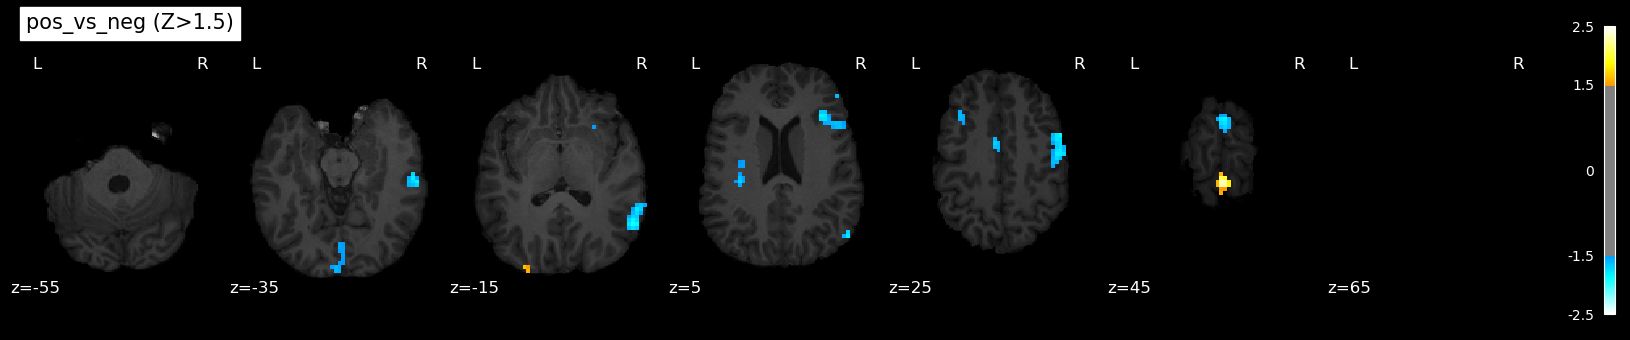

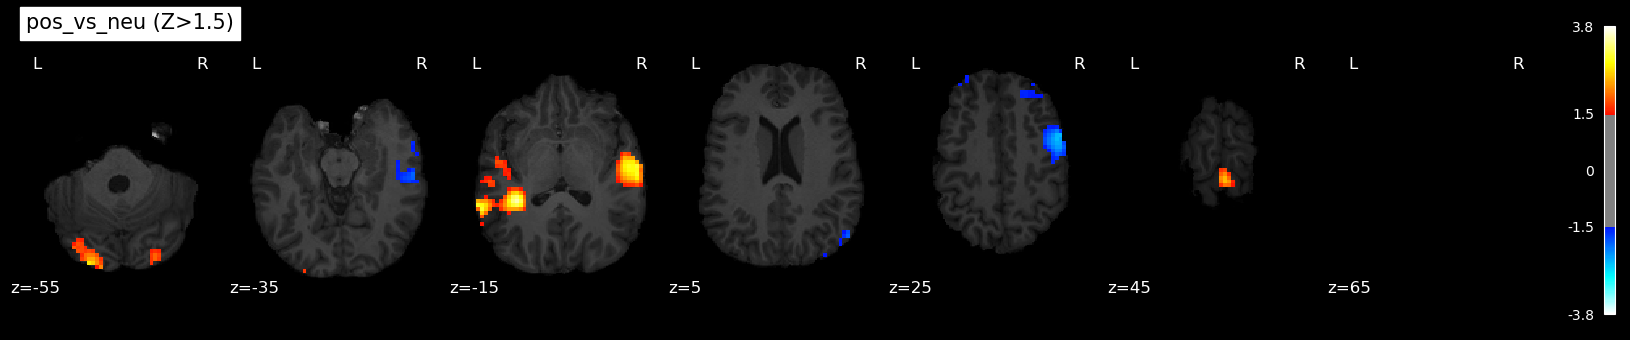

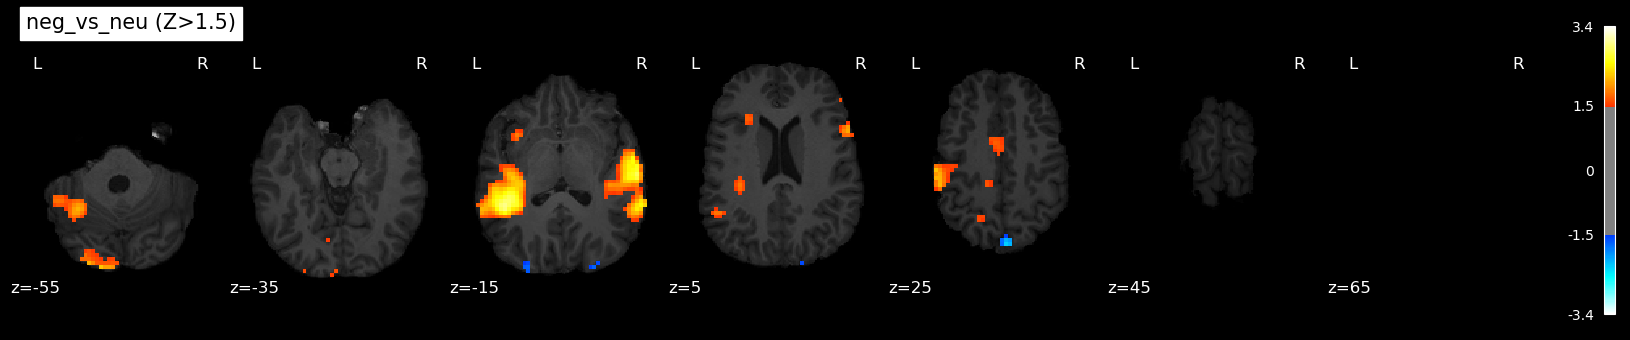

In [55]:
for contrast, weights in contrasts.items():
    z_map = fmri_glm.compute_contrast(weights,
                                      output_type='z_score')
    nib.save(z_map, 'z_map_uncorrected_' + str(contrast) + '.nii.gz')
    plot_stat_map(z_map, bg_img=anat_img, threshold=1.5,
                  display_mode='z', cut_coords=[-55,-35,-15,5,25,45,65], black_bg=True,
                  title=str(contrast)+' (Z>1.5)')
    plt.show()

# ICA

In [81]:
from scipy.stats import zscore
from sklearn.decomposition import FastICA, PCA

img = nib.load(fmri_img)
img_data = img.get_fdata()

affine = nib.load(fmri_img).affine

x,y,z,t = img_data.shape

X= img_data.reshape(315, 320000)
   

X = zscore(X,axis=1) # across subjects
X = np.nan_to_num(X,0) # nan to 0s
print("X matrix size: ", X.shape)
print(X)

X matrix size:  (315, 320000)
[[ 3.7286862   3.52461939  3.47923746 ...  0.10423677  0.0780604
   0.09057626]
 [-0.05217808 -0.01746815 -0.11374533 ...  0.62931125  0.68846331
   0.66458868]
 [-0.25229406 -0.1570586  -0.13332556 ... -2.06068098 -2.06869309
  -2.00870335]
 ...
 [ 0.39032153  0.43622542  0.37358775 ...  2.09108322  1.68913497
   2.13069295]
 [ 1.3574807   1.48911414  1.15455953 ... -0.50616303 -0.53981337
  -0.51371486]
 [ 0.49991503  0.32572291  0.49288147 ... -2.20144388 -2.34471407
  -2.0043498 ]]


In [84]:
#* Run FastICA on X -- check 

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [6,]#20, 60 ...]

## NOTE that 60 components can be computational costly

#* We will transpose the matrix X so that ICA algorithm operates on the voxels dimension.
#* In other words, the estimated sources (S) should be have dimensionality [#voxels]

for n in nb_components:
    print(f"Processing component {n}")
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    ### YOUR CODE HERE
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)

    ica = FastICA(n_components=n, random_state=1, max_iter=10000)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)

    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Processing component 6
Running FastICA with n = 6 components
(320000, 6)
Done


In [72]:
print("The shape of the estimated Sources is: {}".format(S_.shape))

The shape of the estimated Sources is: (320000, 5)


In [73]:
T1w_img = nib.load(op.join(preproc_root, 'sub-control01','anat','sub-control01_T1w.nii.gz'))

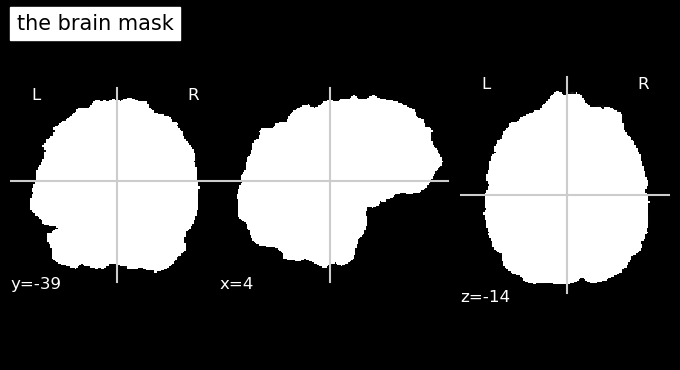

In [74]:
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map, show
from nilearn.image import resample_to_img


#* Build brain mask to restrict analysis within the brain

mask_img = resulting_mask_path
#mask_img = resample_to_img(mask_img, anat_img, interpolation='nearest')
masker = NiftiMasker(mask_img=mask_img)
#masker.fit() # modification
plot_stat_map(mask_img, bg_img =T1w_img, black_bg=True, title='the brain mask', colorbar=False,)

Number of components:  6


/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


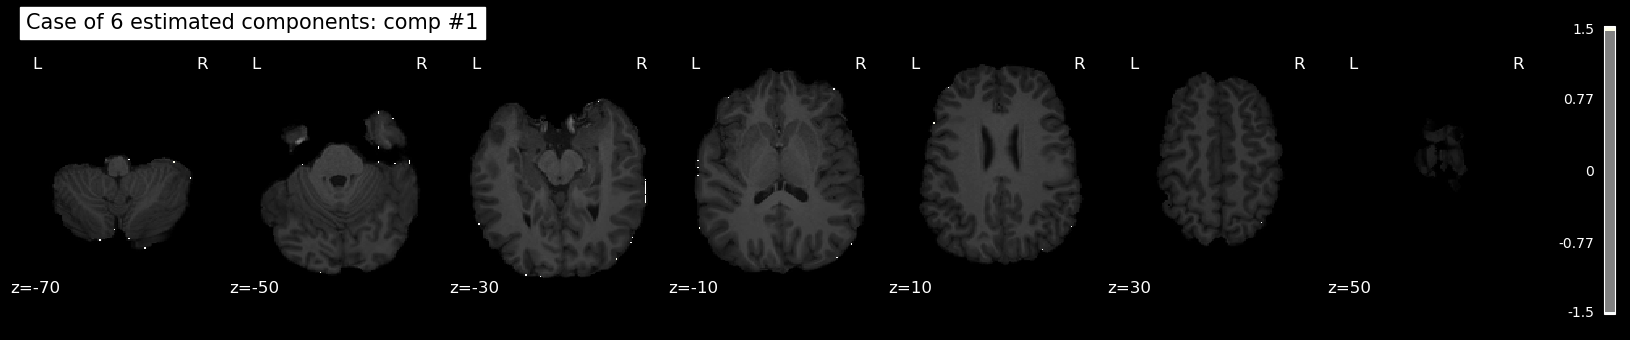

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


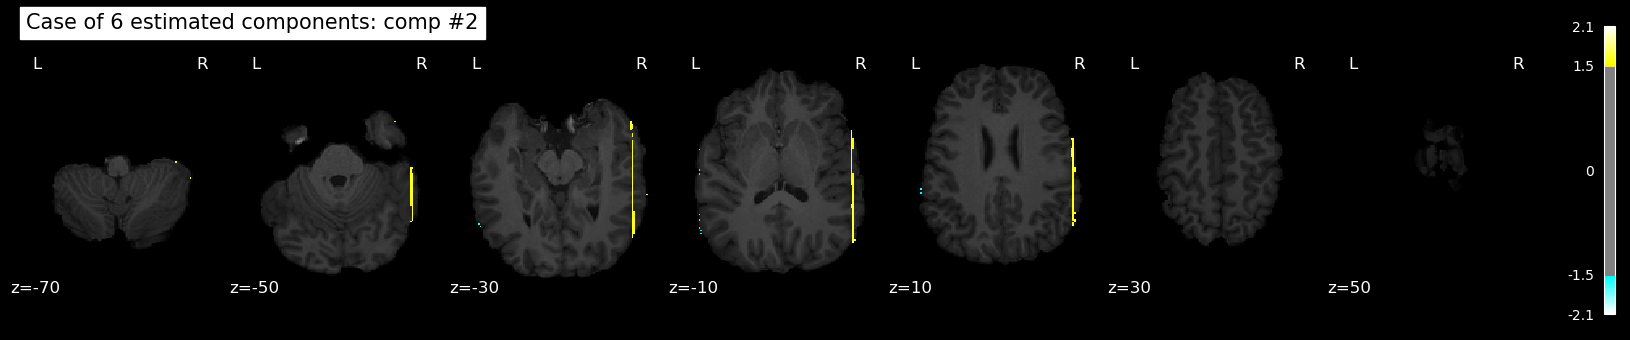

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


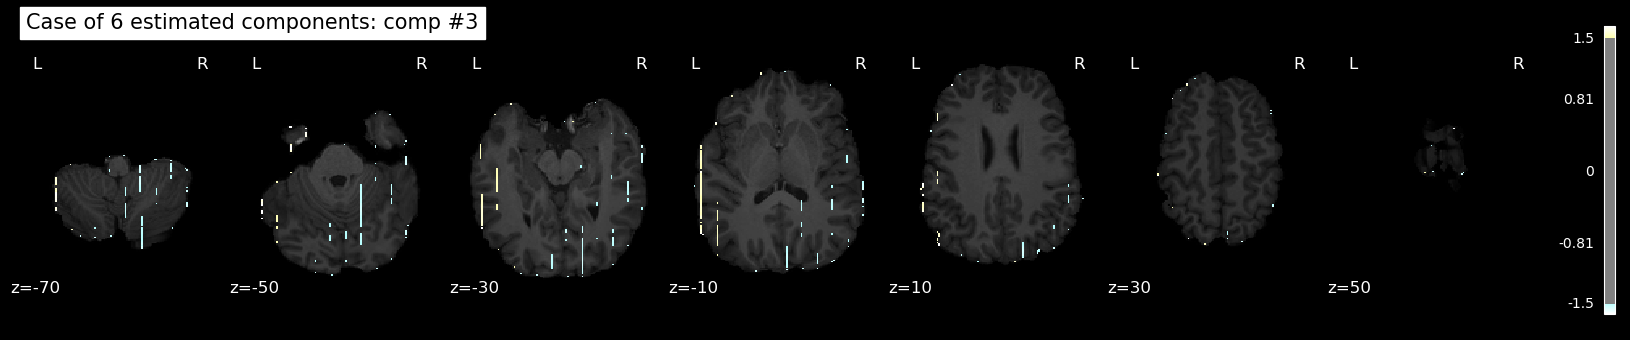

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


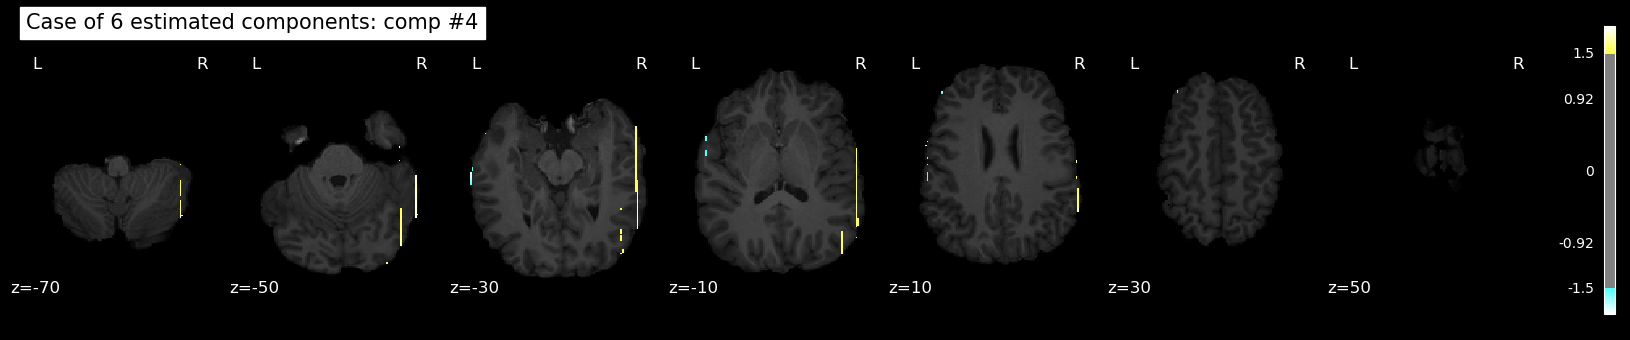

In [87]:
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(4, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        #data = masker.transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=1.5*np.std(s), bg_img=T1w_img, cut_coords=[-70,-50,-30,-10,10,30,50])
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()


In [ ]:
"finish"